In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd /content/drive/My Drive

/content/drive/My Drive


In [12]:
!unzip Image_1.zip

Archive:  Image_1.zip
   creating: Image_1/
  inflating: Image_1/.DS_Store       
   creating: __MACOSX/
   creating: __MACOSX/Image_1/
  inflating: __MACOSX/Image_1/._.DS_Store  
   creating: Image_1/Code/
   creating: Image_1/Configuration/
  inflating: Image_1/Configuration/.DS_Store  
   creating: __MACOSX/Image_1/Configuration/
  inflating: __MACOSX/Image_1/Configuration/._.DS_Store  
  inflating: Image_1/Configuration/config.csv  
  inflating: Image_1/Data.zip        
   creating: Image_1/Input/
  inflating: Image_1/Input/.DS_Store  
   creating: __MACOSX/Image_1/Input/
  inflating: __MACOSX/Image_1/Input/._.DS_Store  
  inflating: Image_1/Input/train_labels.csv  
  inflating: Image_1/Input/validation_labels.csv  
   creating: Image_1/Output/
  inflating: Image_1/Output/.DS_Store  
   creating: __MACOSX/Image_1/Output/
  inflating: __MACOSX/Image_1/Output/._.DS_Store  
  inflating: Image_1/Output/results.csv  
  inflating: Image_1/Round1_Problem1-of-1_Problem.pdf  
  inflating: _

In [0]:
!unzip ./Image_1/Data.zip

In [14]:
import pandas as pd
#importing pandas for reading csv
import numpy as np
#importing numpy for matrix operartions
from collections import defaultdict
#importing defaultdict for making dictionaries

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.models import Model
#functional API

from tensorflow.keras.preprocessing import image
#loading images

from keras.utils import layer_utils

from keras.applications.imagenet_utils import preprocess_input
#preprocessing images

import glob
#importing images

Using TensorFlow backend.


In [61]:
data = pd.read_csv('Image_1/Input/validation_labels.csv')
#importing and reading csv labels through pandas
data

,labels,imageId
0,"[u'62', u'17', u'66', u'214', u'105', u'137', ...",1
1,"[u'95', u'17', u'66', u'214', u'164', u'137', ...",2
2,"[u'122', u'19', u'66', u'186', u'180', u'44', ...",3
3,"[u'190', u'222', u'66', u'153', u'164', u'226'...",4
4,"[u'62', u'66', u'153', u'171', u'111', u'137',...",5
...,...,...
2995,"[u'95', u'17', u'66', u'53', u'184']",2996
2996,"[u'129', u'17', u'66', u'203']",2997
2997,"[u'62', u'17', u'66', u'153', u'171', u'137', ...",2998
2998,"[u'61', u'106', u'49', u'105', u'19', u'111', ...",2999


In [0]:
int_max = -1
#setting int_max -1 to find the number of classes
dict_data = defaultdict(list)
#making a dictionary for storing labels which will be converted to list and then numpy array for feeding
for i in range(len(data)):
    labels = []
    label_id = data['labels'][i]
    list_label = label_id.split(",") #spiltting the extracted label string by ","
    for item in list_label:
        list_int = item.split("'") #splitting the splitted string by "'"
        int_item = int(list_int[1])
        labels.append( int_item ) #got int label from the string labels
        if int_max < int_item:
            int_max = int_item #checking and changing max_int value for finding number of classes
    dict_data[i].append(labels) #appending int labels to dictionary

In [0]:
final_labels = [] #converting multilabels into one hot vectors of size number of classes i.e. int_max
for i in range(len(dict_data)):
    final_label_list = [0]*(int_max) #making a zero valued list of size number of classes
    for j in dict_data[i][0]:
        final_label_list[j-1] = 1 #setting label index of final_labels 
    final_labels.append(final_label_list) #appening lists of one hot vector

In [0]:
final_labels = np.asarray(final_labels) #converting into numpy array

In [0]:
images = [] #making images list
for img in glob.glob("Data/validation/*.jpg"): #iterating images into given folder
    img = image.load_img(img, target_size=(224, 224)) #loading images and resizing to 224*224 as needed by resNet
    x = image.img_to_array(img) #images to array
    #x = preprocess_input(x) #preprocessing to feed in resNet
    images.append(x)# appnding the  images to list

In [0]:
images = np.asarray(images) #converting into numpy array

In [0]:
#making identity block it is just a direct connection without any layer in between

def identity(input_tensor, kernel_size, filters, stage, block):
    
    
    filters1, filters2, filters3 = filters #number of filters  needed for convolving the 3 layers
    
    bn_axis = 3 #batch normalisation along the axis of channels
    
    conv_name = 'res'+ str(stage) + block #setting convolution layer name stage+block
    normal_name = 'normalization' + str(stage) + block #setting branch normalization layer name stage+block

    x = Conv2D(filters1, (1, 1), name=conv_name + 'a1')(input_tensor)
    #feeding in input tensor(image numpy array) and convolving it using number of filter1 and 1*1 kernel size
    
    x = BatchNormalization(axis=bn_axis, name=normal_name+ 'a1')(x)
    #normalizing the batch to centre it's bias and variance
    #done before non-linearity
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,padding='same', name=conv_name + 'b1')(x)
    #applying convolution of number filters2 and kernel size acc to block
    
    x = BatchNormalization(axis=bn_axis, name=normal_name + 'b1')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name + 'c1')(x)
    x = BatchNormalization(axis=bn_axis, name=normal_name  + 'c1')(x)

    x = layers.add([x, input_tensor])
    #skip/residual connection from direct input without any layer in between
    x = Activation('relu')(x)
    
    return x

In [0]:
#making shortcut connection which contains linear layer

def shortcut(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    
    
    filters1, filters2, filters3 = filters
    bn_axis = 3
    
    conv_name = 'res' + str(stage) + block
    normal_name = 'normalization' + str(stage) + block

    x = Conv2D(filters1, (1, 1), strides=strides,name=conv_name + 'a1')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=normal_name+ 'a1')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',name=conv_name + 'b1' )(x)
    x = BatchNormalization(axis=bn_axis, name=normal_name+ 'b1' )(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name + 'c1')(x)
    x = BatchNormalization(axis=bn_axis, name=normal_name + 'c1')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides, name=conv_name + '1')(input_tensor)
    #skip/residual connections' middle layer joined with input tensor
    shortcut = BatchNormalization(axis=bn_axis, name=normal_name + '1')(shortcut)

    x = layers.add([x, shortcut])
    #making residual connection with shortcut in between
    x = Activation('relu')(x)
    return x

In [0]:
def ResNet50(include_top=True,pooling=None,classes=int_max):

    input_shape = (224, 224, 3)
    #input tensors' shape
    img_input = Input(shape=input_shape)
    
    bn_axis = 3
    #batch normalization axis
    
    x = ZeroPadding2D((3, 3))(img_input)
    #padding the input tensors with zeros for considering edges of the images
    
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='normal_conv1')(x)
    x = Activation('relu')(x)
    
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    #max pooling for getting max value in the window of size 3*3
    #with stride 2*2
    
    x = shortcut(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity(x, 3, [64, 64, 256], stage=2, block='c')
    #3 blocks
    
    x = shortcut(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity(x, 3, [128, 128, 512], stage=3, block='d')
    #4 blocks
    
    x = shortcut(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity(x, 3, [256, 256, 1024], stage=4, block='f')
    #6 blocks
    
    x = shortcut(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity(x, 3, [512, 512, 2048], stage=5, block='c')
    #3 blocks
    
    x = AveragePooling2D((7, 7), name='avg_pool')(x)
    #average pooling to get a average in a window of size 7*7
    
    x = Flatten()(x)
    #flattening conv feature output to make a fully connected layer
    
    x = Dense(classes, activation='sigmoid', name='fully_connected')(x)
    #number of output neurons equals to the size of number of classes
    #with activation sigmoid for multi-label classification
    
    inputs = img_input
    
    # Create model.
    model = Model(inputs, x, name='resnet50')

    # load weights
    return model

In [0]:
model = ResNet50()
#initiating model

In [71]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
normal_conv1 (BatchNormalizatio (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [0]:
opt = keras.optimizers.Adam(lr=0.0001)
#using Adam optimizer with learning rate 0.001
model.compile(optimizer=opt, loss='binary_crossentropy')
#compiling model with binary_crossentropy loss
#i.e {−(ylog(p)+(1−y)log(1−p))}
#for our case it is multi-class −∑c=1Myo,clog(po,c)

In [0]:
batch_size = 16
iterations = 10000

In [0]:
import matplotlib.pyplot as plt

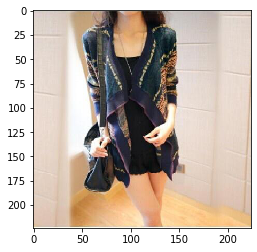

In [76]:
plt.imshow(images[693]/255.0)

In [77]:
start = 0
for step in range(iterations):
    
    stop = start + batch_size #bound limit for batch_size also end of next batch
    
    batch_imgs = images[start: stop]/255.0 #extracting batch from images
    batch_labels = final_labels[start: stop] #extracting batch from labels
    
    loss = model.train_on_batch(batch_imgs, batch_labels) #training and getting loss
    
    start += batch_size #aggregating size of datset also start of next batch
    if start > len(images) - batch_size: #if size exceeds restart
      start = 0

    #Occasionally save / plot
    if step % 100 == 0:
        # Save model weights
        model.save_weights('model.h5')

        # Print metrics
        print('loss at step %s: %s' % (step, loss))

loss at step 0: 0.8726824
loss at step 100: 0.09681887
loss at step 200: 0.10288881
loss at step 300: 0.10108637
loss at step 400: 0.10358474
loss at step 500: 0.10598713
loss at step 600: 0.11023336
loss at step 700: 0.11154494
loss at step 800: 0.10698265
loss at step 900: 0.09942675
loss at step 1000: 0.10721386
loss at step 1100: 0.10479718
loss at step 1200: 0.10169744
loss at step 1300: 0.100581005
loss at step 1400: 0.10211319
loss at step 1500: 0.09505927
loss at step 1600: 0.10204086
loss at step 1700: 0.09314655
loss at step 1800: 0.08498001
loss at step 1900: 0.09280937
loss at step 2000: 0.08326071
loss at step 2100: 0.078655824
loss at step 2200: 0.0911969
loss at step 2300: 0.06684279
loss at step 2400: 0.06486829
loss at step 2500: 0.07292861
loss at step 2600: 0.046357967
loss at step 2700: 0.06992163
loss at step 2800: 0.054513365
loss at step 2900: 0.045873117
loss at step 3000: 0.041073166
loss at step 3100: 0.035152342
loss at step 3200: 0.028642165
loss at step 330

In [0]:
#making a batch for testing model
test_images = []
i=0
for img in glob.glob("Data/train/*.jpg"):
    if i == 20 :
      break
    img = image.load_img(img, target_size=(224, 224))
    x = image.img_to_array(img)
    x = preprocess_input(x)
    test_images.append(x)
    i = i + 1
test_images = np.asarray(test_images)

In [0]:
prediction = model.predict(test_images)
#getting prediction tensor

In [80]:
prediction.shape

(20, 228)

In [0]:
#rounding off predictions into one and zero for batch_size =20 and number_of_classes = 228
for j in range(20):
  for i in range(228):
    if prediction[j][i] >= 0.5:
      prediction[j][i] = 1
    else:
      prediction[j][i] = 0

In [0]:
def top_ten_class(prediction):
    
    sum_pred = np.zeros(228)  
    for i in prediction:
        sum_pred = i + sum_pred #summing all the prediction element wise
    top_ten_idx = (-sum_pred).argsort()[:10] # finding index of top ten maximum elements in the tensor 
    return top_ten_idx

In [0]:
indexes = top_ten_class(prediction)

In [84]:
indexes

array([153,  81, 179, 149,  65, 122, 219, 185, 203, 188])